# Climate Model Package Tutorial

Climate science has experienced a large growth in interest over the past several decades, especially with regards to changing climate trends like temperature, weather patterns, and sea levels. This package allows the user to do parameter estimation and model comparison using Bayesian inference. While only a few models are supported in the package, the user is capable of modifying the source code to add new models with minimal effort.

## Imports

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the data IO and modeling packages:

In [2]:
# Modules for climate model analysis
from climate import data_io
from climate.inference import model
from climate.pySCM.SimpleClimateModel_opt import *

## Example data

The data against which we compare our model is a timeseries of global **temperature anomaly** averages. Begin by calling `get_example_data_file_path`, which takes as input the name of the file and the location of the data file (the `data/` directory is the default) and returns the location of the file.

In [3]:
fileload = data_io.get_example_data_file_path(
    'global_surface_temp_seaice_air_infer.txt')

Now we call `load_data_temp`, which takes the file location as input and returns a Pandas data frame containing temperature data. Note that this function's behavior is specific to the format of the text file for temperature data obtained from the Berkeley group.

In [4]:
# Load data and obtain numpy arrays for data and uncertainty
data = data_io.load_data_temp(fileload)
year = data['year'].values
temperature = data['monthly_anomaly'].values
tempUnc = data['monthly_anomaly_unc'].values

We'll be comparing these actual data to a simple climate model which takes as input several timeseries of greenhouse gas emissions.  The emissions data are provided at yearly intervals, and the predicted temperature anomaly from the simple climate model is given at the same years spanned by the emissions data.  The temperature anomaly data that we imported above, however, is provided at monthly intervals.  To ensure that the temperature data and model predictions have the same temporal resolution, we will compute yearly averages and uncertainties (by adding in quadrature):

In [5]:
# Temperature data are recorded at monthly intervals, but we will 
# compute yearly averages and uncertainties to match the (yearly) 
# resolution of the emissions files
year = (data['year'].values)[0::12]
#temperature = temperature[0::12]
temperature = data.groupby('year').mean()['monthly_anomaly'].values
# Uncertainties in the data files correspond to 95% CL (2-sigma), 
# divide these values by 2 to obtain 68% CL (1-sigma)
tempUnc = data['monthly_anomaly_unc'].values / 2
# tempUnc has length 2018, so we will pad with zeros to get something with
# a length that is divisible by 12, which will make it easier to compute the 
# propagated error uncertainty for each year
tempUnc = np.append(tempUnc,[0,0,0,0,0,0,0,0,0,0])
tempUnc = tempUnc.reshape(169,12)
tempUnc = np.array([data_io.add_in_quad(errs) for errs in tempUnc])

Now we will plot the temperature anomaly and errorbars obtained from the data file:

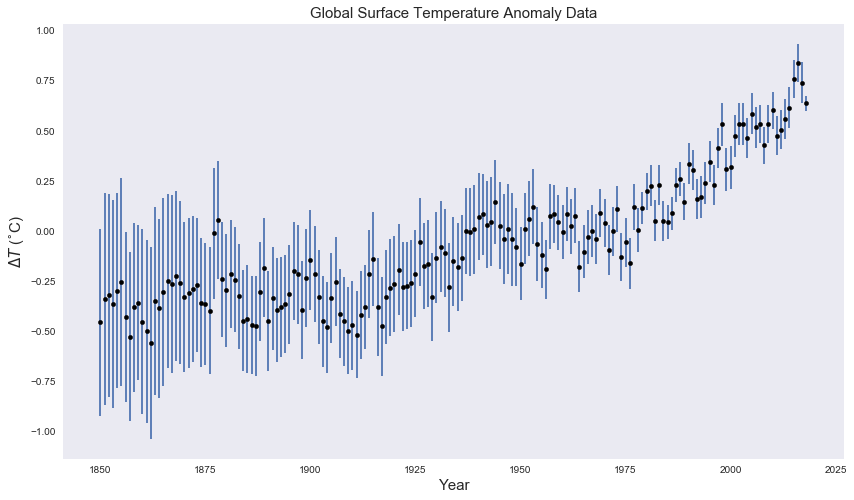

In [6]:
# We can plot temperature anomaly vs. time
plt.figure(figsize=(14,8))
plt.errorbar(year, temperature, tempUnc, linestyle='none')
plt.scatter(year, temperature, c='k', zorder=5, s=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('$\Delta T$ ($^{\circ}$C)', fontsize=15)
plt.title('Global Surface Temperature Anomaly Data', fontsize=15);
plt.grid()

Now that the data is imported, we can do parameter estimation on a model. We use the package `pySCM`, which is a simple model for temperature change that uses emissions curves for 4 green house gases. We use a modified version of this model with 5 parameters: overall temperature shift (to exchange between temperature change and anomoly), and 4 overall normalization factors for the emissions curves. This model is called `ModifiedSimpleClimateModel`. The user can create an instance of this model and offer the data as input to the constructor:

In [7]:
# Create Modified Simple Climate Model instance
SCM = model.ModifiedSimpleClimateModel(year, temperature, tempUnc)

Next, the user should set the priors on the model parameters. Each instance of `Model` (superclass of `ModifiedSimpleClimateModel`) has as a field an array of `ndim` instances of `Prior`, each of which can be called once initialized. To see this in action, we initialize the model priors by giving it an array of length `ndim` containing strings of the prior type (uniform, guassian, or jeffreys) and two arrays containing the 2 parameters of the prior. For simplifity, we use uniform priors:

In [13]:
# Set priors on parameters
prior_type = [ 'uniform','gaussian','gaussian','gaussian','gaussian' ]
prior_param1 = [-1.0, 1.0, 1.0, 1.0, 1.0]
prior_param2 = [ 1.0, 0.1, 0.1, 0.1, 0.1]
SCM.set_priors(prior_type, prior_param1, prior_param2)

Now we can call each of these priors and check that they give the expected distribution. To obtain a particular prior (which can be called as a function), call `SCM.priors`, which is an array, so `SCM.priors[i]` is the prior of the $i^\text{th}$ parameter of the model:

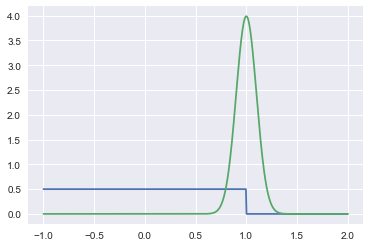

In [14]:
# Test that priors are working as expected
test_x = np.linspace(-1, 2, 500)
test_prior_1 = [ np.exp(SCM.priors[0](tx)) for tx in test_x ]
test_prior_2 = [ np.exp(SCM.priors[1](tx)) for tx in test_x ]
plt.plot(test_x, test_prior_1)
plt.plot(test_x, test_prior_2)

Note that these distributions are normalized to unity.

Now that the model and its priors are initialized, we can run a Markov-Chain Monte Carlo algorithm implemented by the package `emcee`. To do this, create an array of initial guesses of the model parameters. Then call `run_MCMC` with this array, the number of walkers to use, and the number of steps for each walker:

In [15]:
# Run MCMC on the model
paramGuess = [-0.4, 1., 1., 1., 1.]
%time SCMsample = SCM.run_MCMC(paramGuess, nwalkers=10, nsteps=400)

Progress: 
[################################################################################]

CPU times: user 27.1 s, sys: 1.33 s, total: 28.5 s
Wall time: 28.4 s


The user can then call `show_results` on the model with the number of initial steps to skip (burn-in). The function displays a histogram and kernel-density for each of the parameters (marginalized over all others). The data and best-fit for the model are plotted together. The best-fit values reported are the medians and the intervals are the 16$^\text{th}$ and 84$^\text{th}$ percentiles.

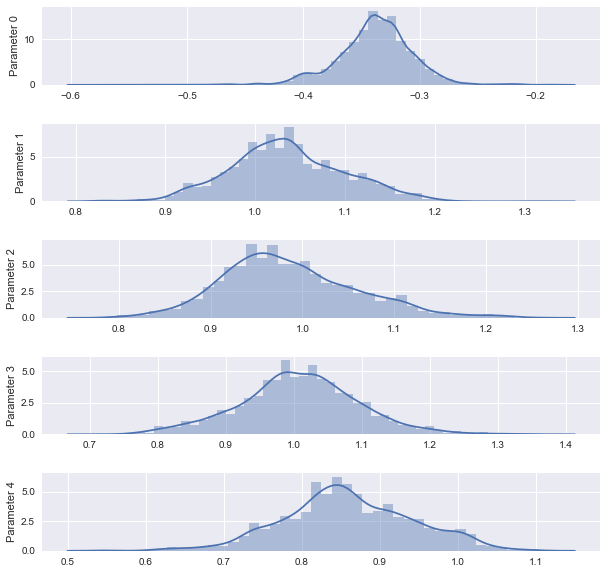

Param 0 = -0.336932 + 0.026890 - 0.029064
Param 1 = 1.032765 + 0.069375 - 0.056590
Param 2 = 0.975605 + 0.083689 - 0.058346
Param 3 = 1.007652 + 0.082726 - 0.083160
Param 4 = 0.853694 + 0.092637 - 0.074596


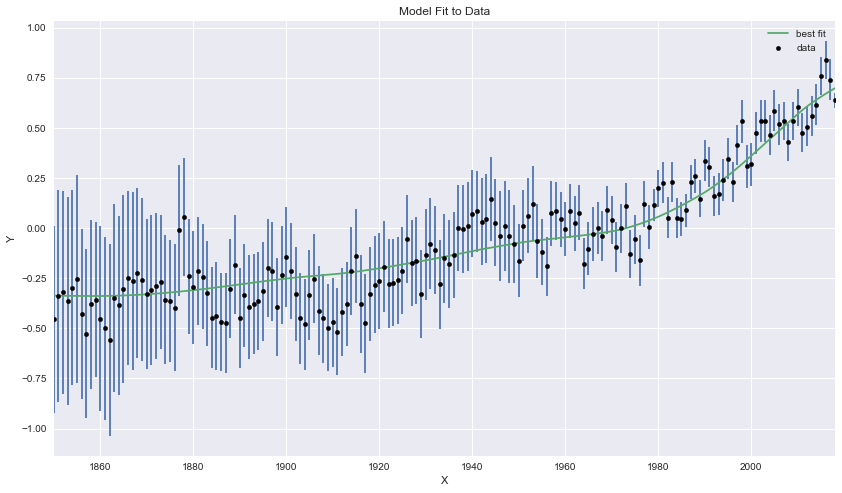

In [16]:
# Plot results from the sampling
SCM.show_results(burnin=100)

We also have a class `BasicCloudSeedingModel`, which is a 2-parameter model for cloud seeding based off of solar activity data. In particular, we use solar flare index as the input for our model. Again, we use `data_io` to read in the data in the same fashion as before and generate a plot of the data:

In [6]:
# Cloud Seeding Model, plot of flare data
fileload = data_io.get_example_data_file_path(
    'flare-index_total_*.txt', data_dir='data/flares')
data_flares = data_io.load_data_flare(fileload, verbose=0)

In [7]:
# Get np.arrays for data series
years_flares = data_flares['years'].values
flares = data_flares['flares_index_mean'].values
flares_unc = data_flares['flares_index_unc'].values

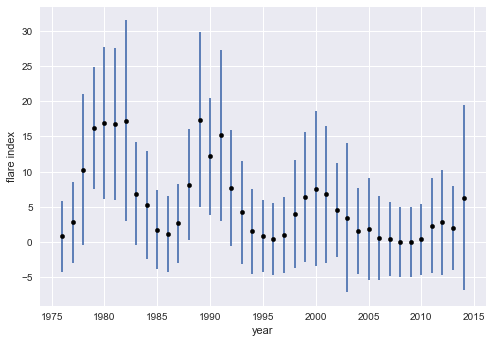

In [8]:
#Plot the data
plt.errorbar(years_flares, flares, flares_unc,  linestyle='none')
plt.scatter(years_flares, flares, c='k', zorder=5, s=20, label='data')
plt.xlabel('year')
plt.ylabel('flare index');

The simple model for cloud seeding is the following:
$$ \Delta T_i = \alpha \times  a_{\rm sun, i-i_{lag}}, $$
where $\alpha$ is a normalization constant, $i_{\rm lag}$ is a index offset corresponding to the time lag between the seeding of clouds and the impact on temperature, and $a_{\rm sun, i}$ is the $i^\text{th}$ data point of solar activity.
Using these solar flare data, let's create an instance of <code>BasicCloudSeedingModel</code> from the <code>model</code> package; it takes as input the temperature data (first three parameter fields) and the solar data (last two parameters).

In [20]:
# Test Cloud Seeding Model
CSModel = model.BasicCloudSeedingModel(year, temperature, tempUnc, years_flares, flares, flares_unc)

As described above, the cloud seeding model has two parameters, $\alpha$ and $t_{\rm lag}$, so we set priors for these parameters as before:

In [21]:
# Set priors on parameters
# param2 is placeholder for poisson since it only needs one parameter
prior_type = ['uniform', 'poisson' ]
prior_param1 = [-0.5, 1]
prior_param2 = [ 0.5, -1]
CSModel.set_priors(prior_type, prior_param1, prior_param2)

What if ALL variation in global temperature were a result of cloud seeding?  This is unreasonable, but we can still assume this is the case and compute best-fit parameters:  

In [22]:
# Run MCMC on the cloud seeding model
paramGuess = [0, 0]
%time CSModelSample = CSModel.run_MCMC(paramGuess, nwalkers=50, nsteps=500)

/Users/MRowan/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/MRowan/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Progress: 
[################################################################################]

CPU times: user 6.45 s, sys: 727 ms, total: 7.18 s
Wall time: 6.58 s


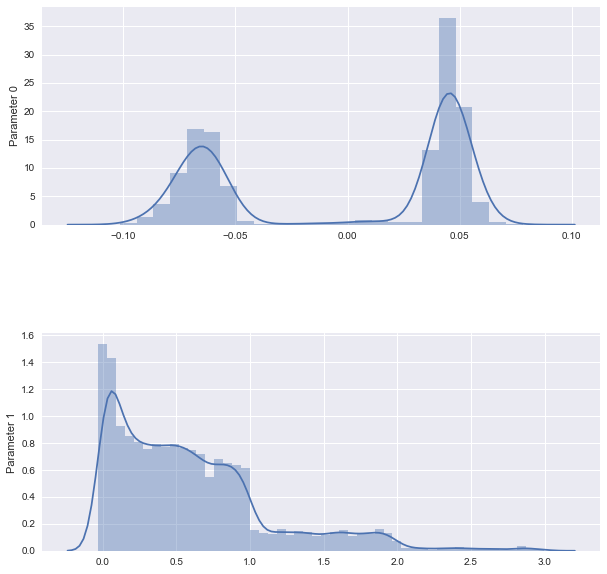

Param 0 = 0.039248 + 0.009881 - 0.107682
Param 1 = 0.483855 + 0.499739 - 0.409628


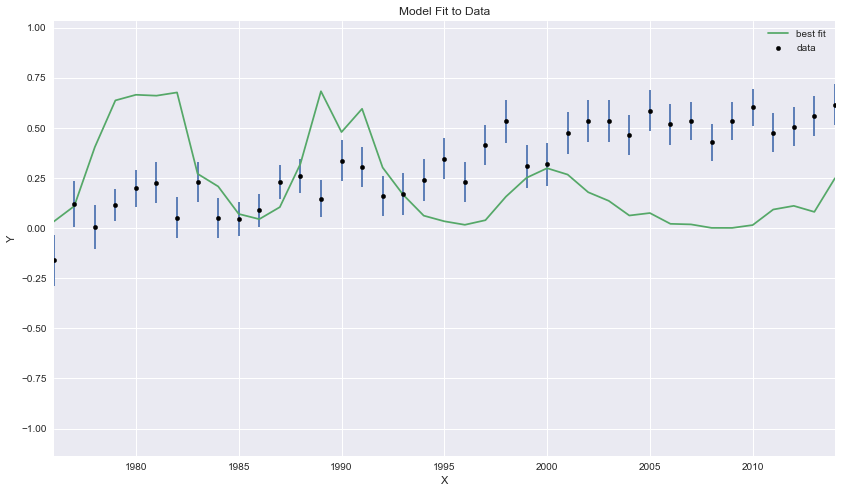

In [23]:
# Plot results from the sampling
CSModel.show_results(burnin=100)

So far, we've defined a simple climate model, and also a basical cloud seeding model.  We can use the <code>CombinedModel</code> class to merge the two models, and perform parameter estimation on the models. To do this, we again make arrays for the priors (this time there are 7 total parameters), create an instance of `CombinedModel` that takes as input the models to combine, and then we call `set_priors` as before:

In [24]:
# Initialize CombinedClimateModel and its priors
prior_type = ['uniform','gaussian','gaussian','gaussian','gaussian','uniform','poisson']
prior_param1 = [-0.5, 1.0, 1.0, 1.0, 1.0, -0.5,  1]
prior_param2 = [ 0.5, 0.1, 0.1, 0.1, 0.1,  0.5, -1]
CombinedClimateModel = model.CombinedModel(SCM, CSModel)
CombinedClimateModel.set_priors(prior_type, prior_param1, prior_param2)

We then call `run_MCMC` on the combined model as before:

In [25]:
# Run MCMC on combined model
paramGuess = [-0.4, 1.,1.,1.,1., 0., 1.]
%time combined_model_sample = CombinedClimateModel.run_MCMC(paramGuess, nwalkers=14, nsteps=350)

Progress: 
[################################################################################]

CPU times: user 32.7 s, sys: 1.6 s, total: 34.3 s
Wall time: 34.3 s


And as before, we can show the results of the algorithm using `show_results`:

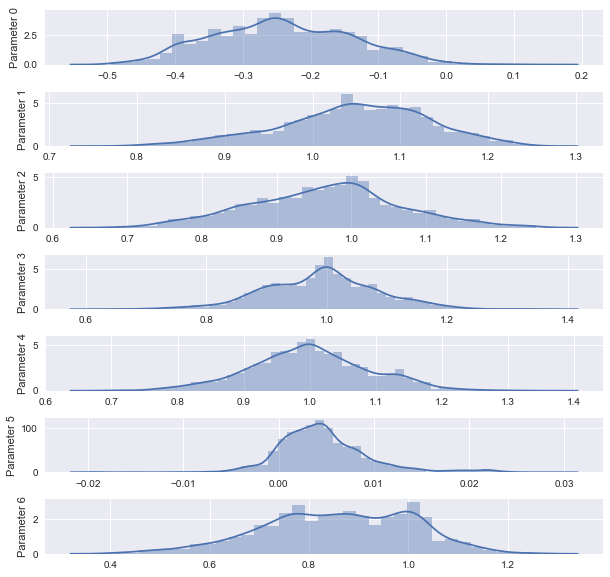

Param 0 = -0.246268 + 0.111891 - 0.103322
Param 1 = 1.052848 + 0.075324 - 0.086575
Param 2 = 0.969840 + 0.092284 - 0.110796
Param 3 = 0.994388 + 0.084753 - 0.095497
Param 4 = 0.998381 + 0.092656 - 0.084887
Param 5 = 0.004223 + 0.004264 - 0.003563
Param 6 = 0.863294 + 0.147439 - 0.155578


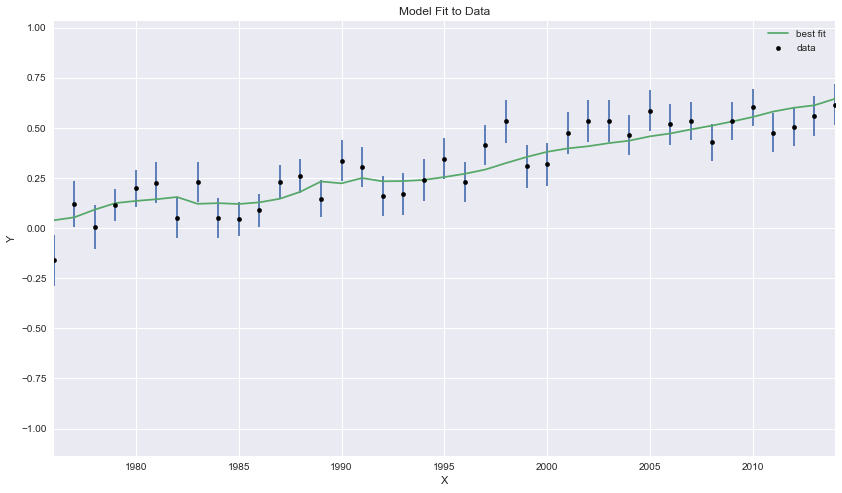

In [26]:
# Show the results of the MCMC algorithm
CombinedClimateModel.show_results(burnin=100)

# Generative model

Both the SCM and cloud seeding models are deterministic. There are two sources of uncertainties in our case - random noise in temperature measurement, and a model uncertainty originating from the uncertainty of solar data (the independent variable).

We use Gaussian models for both the random noise of temperature anomaly measurement and uncertainty of solar data, with one-sigma standard deviation being the widths of the Gaussians. This is because when we have no better information about the distribution of the errors except its width/spread, a Gaussian is the least commital (maximum entropy) choice, which avoids underestimating the uncertainty in the posterior.

For the purpose of this discussion we neglect the time lag parameter in the solar cloud seeding model and calculate the model uncertainty via $$\sigma_{z_i} = |dz_i/da_{sun,i}| \sigma_{sun,i} = |\alpha| \sigma_{sun,i},$$ where $z_i$ is the i-th model prediction, $a_{sun,i}$ is the i-th solar data (independent variable of the model), and $\sigma_{sun,i}$ is the uncertainty in this independent variable.

Thus we have 

$$P(Z_i|\theta, M)=  f_Z(z_i)= \frac{1}{\sqrt{2 \pi \alpha^2 \sigma_{{\rm sun},i}^2}}
 \exp\left(\frac{-(z_{i}- \alpha a_{{\rm sun},i})^2}{2 \alpha^2 \sigma_{{\rm sun},i}^2}\right).$$

For the random error of temperature measurement we have

$$P(E_i|\theta, M)=  f_E(y_i-z_i)= \frac{1}{\sqrt{2 \pi \sigma_{i}^2}}
 \exp\left(\frac{-e_{i}^2}{2 \sigma_{i}^2}\right),$$ where $y_i$ is the measured value of temperature anomaly and $\sigma_{i}$ is the random noise in temperature measurement.

The two sources of uncertainty are independent.

Now $p(Y_i|\theta, M)$ is the convolution of $f_Z(z_i)$ and $f_E(y_i-z_i)$. In the case where both functions are Gaussians, the convolution yields a particularly simple result for the $i^{\rm th}$ data point:

$$P(Y_i|\theta, M)=  \frac{1}{\sqrt{2 \pi (\sigma_{i}^2 + \alpha^2 \sigma_{{\rm sun},i}^2)}}
 \exp\left(\frac{-(y_{i}- \alpha a_{{\rm sun},i})^2}{2 (\sigma_{i}^2 + \alpha^2 \sigma_{{\rm sun},i}^2)}\right).$$

Also, we assume that the data points at different times are independent, so the likelihood function is a product of $p(Y_i|\theta, M)$ for all $Y_i$'s.


Development is ongoing and with it the writing of this tutorial!

# Incorporating error on emissions data

To incorporate errors from emissions data into our generative model we will use Gaussian Process Regression to sample the possible space of emissions curves.  We use the <code>PYTHON</code> package 'george'.

In [8]:
from climate import data_io
from climate.inference import model
from climate.pySCM.SimpleClimateModel_opt import *
import george
from george.kernels import ExpSquaredKernel

# Set up a Gaussian process
kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

Let's plot the emissions curves from pySCM, and some of the samples we can get using george:

In [7]:
# create simple climate model with no t_lag, and emissions curves normalizations of unity
fileload = data_io.get_example_data_file_path(
    'SimpleClimateModelParameterFile.txt', data_dir='pySCM')
SCM = SimpleClimateModel(fileload, [0,1,1,1,1])

# get the emissions curves from model
ems_CO2 = SCM.emissions['CO2']
ems_CH4 = SCM.emissions['CH4']
ems_N2O = SCM.emissions['N2O']
ems_SOx = SCM.emissions['SOx']

# errors, based roughly on literature (reference)
#ems_CO2_err = model.emissions['CO2']*0.05
#ems_CH4_err = model.emissions['CH4']*0.05
#ems_N2O_err = model.emissions['N2O']*0.05
#ems_SOx_err = model.emissions['SOx']*0.05
ems_CO2_err = np.ones_like(SCM.emissions['CO2'])*0.75
ems_CH4_err = np.ones_like(SCM.emissions['CH4'])*0.75
ems_N2O_err = np.ones_like(SCM.emissions['N2O'])*0.75
ems_SOx_err = np.ones_like(SCM.emissions['SOx'])*0.75

# the years for emissions curves 
yrs = SCM.yrs

Now we add our data and errors to the gaussian process to see what kind of functions are sampled:

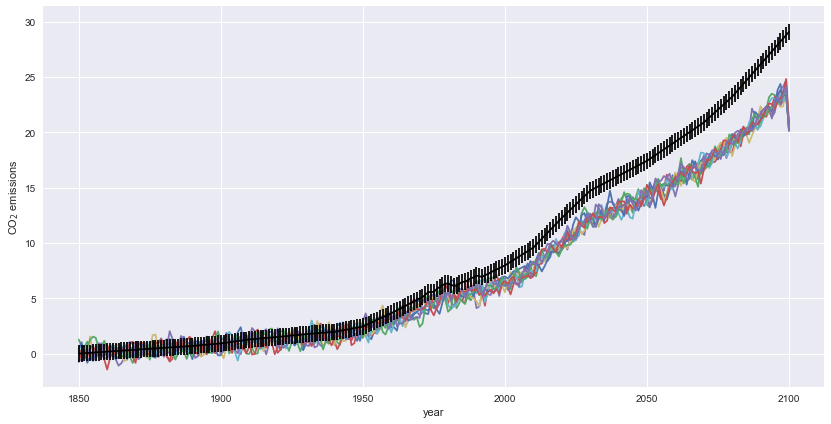

In [8]:
gp.compute(yrs, ems_CO2_err)

fig, ax = plt.subplots(figsize=(14,7))
for pred in gp.sample_conditional(ems_CO2,yrs,10):
    ax.plot(yrs, pred)
    
ax.errorbar(yrs, ems_CO2, yerr=ems_CO2_err, color='k', zorder=3)
ax.set_xlabel('year')
ax.set_ylabel('CO$_2$ emissions')

In [11]:
SCM_gp = model.ModifiedSimpleClimateModel_gp(year, temperature, tempUnc)
paramGuess = [-0.4, 1., 1., 1., 1.]
# Set priors on parameters
prior_type = [ 'uniform','gaussian','gaussian','gaussian','gaussian' ]
prior_param1 = [-1.0, 1.0, 1.0, 1.0, 1.0]
prior_param2 = [ 1.0, 0.1, 0.1, 0.1, 0.1]
SCM_gp.set_priors(prior_type, prior_param1, prior_param2)
%time SCMsample = SCM_gp.run_MCMC(paramGuess, nwalkers=40, nsteps=700)

Progress: 
[################################################################################]

CPU times: user 2h 57min 10s, sys: 3min 27s, total: 3h 37s
Wall time: 43min 3s


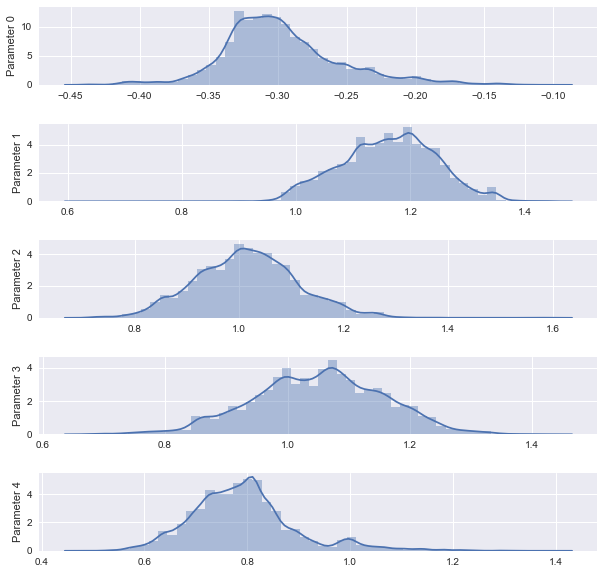

Param 0 = -0.303219 + 0.044985 - 0.028592
Param 1 = 1.165805 + 0.077889 - 0.092061
Param 2 = 1.013526 + 0.092429 - 0.094165
Param 3 = 1.054983 + 0.104074 - 0.111195
Param 4 = 0.783605 + 0.086947 - 0.084532


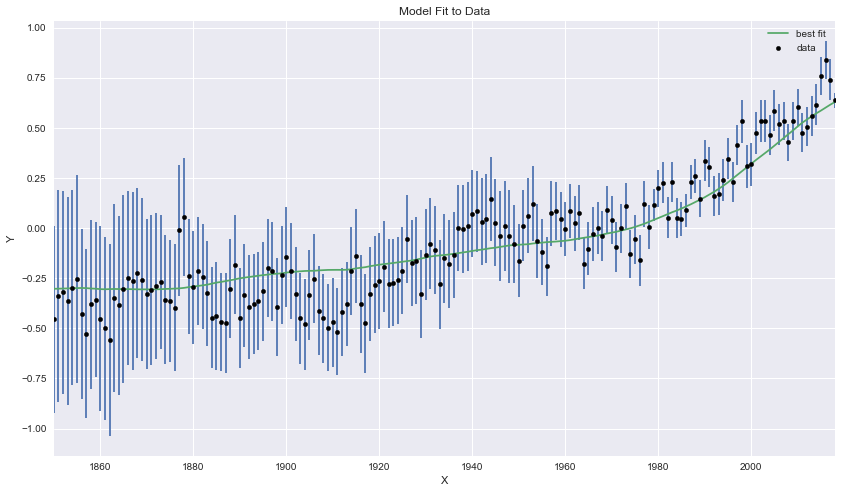

In [12]:
# Plot results from the sampling
SCM_gp.show_results(burnin=100)

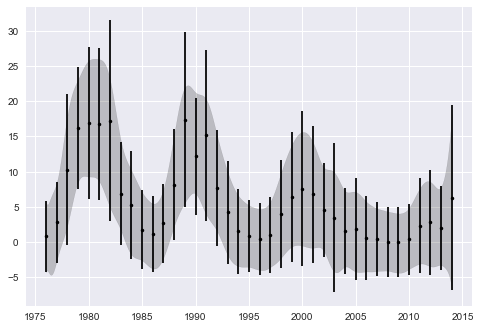

In [9]:
CSModel_gp = model.BasicCloudSeedingModel_gp(year, temperature, tempUnc, years_flares, flares, flares_unc)

In [10]:
SCM_gp = model.ModifiedSimpleClimateModel_gp(year, temperature, tempUnc)
paramGuess = [-0.4, 1., 1., 1., 1.]
# Set priors on parameters
prior_type = [ 'uniform','gaussian','gaussian','gaussian','gaussian' ]
prior_param1 = [-1.0, 1.0, 1.0, 1.0, 1.0]
prior_param2 = [ 1.0, 0.1, 0.1, 0.1, 0.1]
SCM_gp.set_priors(prior_type, prior_param1, prior_param2)
#%time SCMsample = SCM_gp.run_MCMC(paramGuess, nwalkers=40, nsteps=700)

In [11]:
prior_type = ['uniform','gaussian','gaussian','gaussian','gaussian','uniform','poisson']
prior_param1 = [-0.5, 1.0, 1.0, 1.0, 1.0, -0.5,  1]
prior_param2 = [ 0.5, 0.1, 0.1, 0.1, 0.1,  0.5, -1]
CombinedClimateModel = model.CombinedModel(SCM_gp, CSModel_gp)
CombinedClimateModel.set_priors(prior_type, prior_param1, prior_param2)

In [12]:
paramGuess = [-0.4, 1.,1.,1.,1., 0., 1.]
%time combined_model_sample = CombinedClimateModel.run_MCMC(paramGuess, nwalkers=20, nsteps=400)

Progress: 
[################################################################################]

CPU times: user 51min 49s, sys: 1min 5s, total: 52min 55s
Wall time: 12min 38s


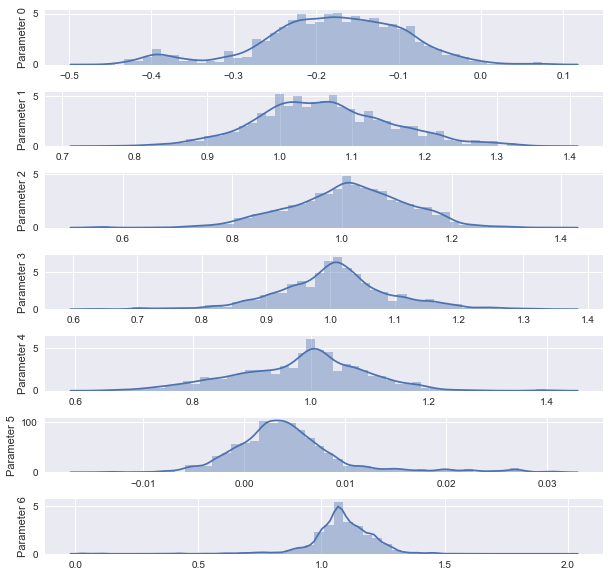

Param 0 = -0.175351 + 0.079939 - 0.080126
Param 1 = 1.057753 + 0.095509 - 0.082870
Param 2 = 1.014103 + 0.104069 - 0.108572
Param 3 = 1.006903 + 0.078668 - 0.079054
Param 4 = 0.996339 + 0.087571 - 0.126829
Param 5 = 0.003653 + 0.004532 - 0.004117
Param 6 = 1.082124 + 0.115007 - 0.083540


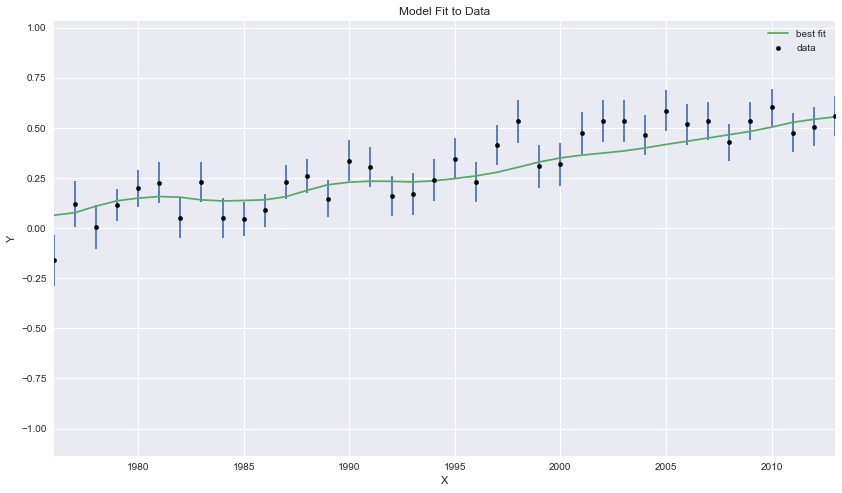

In [13]:
CombinedClimateModel.show_results(burnin=100)

# Miscellaneous testing

In [7]:
# Modules for climate model analysis
from climate import data_io
from climate.inference import model
from climate.pySCM.SimpleClimateModel_opt import *

In [8]:
fileload = data_io.get_example_data_file_path(
    'SimpleClimateModelParameterFile.txt', data_dir='pySCM')
model = SimpleClimateModel(fileload, [0,1,1,1,1])
model.runModel()

In [ ]:
prior_type = ['uniform','gaussian','gaussian','gaussian','gaussian','uniform','poisson']
prior_param1 = [-0.5, 1.0, 1.0, 1.0, 1.0, -0.5,  1]
prior_param2 = [ 0.5, 0.1, 0.1, 0.1, 0.1,  0.5, -1]
CombinedClimateModel = model.CombinedModel(SCM, CSModel)
CombinedClimateModel.set_priors(prior_type, prior_param1, prior_param2)

In [9]:
model.temperatureChange

array([  0.00000000e+00,  -2.01313103e-04,  -5.35168154e-04,
        -9.45295731e-04,  -1.38556710e-03,  -1.81833260e-03,
        -2.21308515e-03,  -2.54534443e-03,  -2.79571211e-03,
        -2.94906770e-03,  -2.99388210e-03,  -2.92163121e-03,
        -2.72629467e-03,  -2.40392772e-03,  -1.95229572e-03,
        -1.37056257e-03,  -6.59025791e-04,   1.81108479e-04,
         1.14791581e-03,   2.23891409e-03,   3.45119848e-03,
         4.78155432e-03,   6.22655115e-03,   7.78262051e-03,
         9.44611983e-03,   1.12133846e-02,   1.30807704e-02,
         1.50446863e-02,   1.71016215e-02,   1.92481653e-02,
         2.14810224e-02,   2.37970237e-02,   2.61931338e-02,
         2.86664555e-02,   3.12142318e-02,   3.38338463e-02,
         3.65228215e-02,   3.92788167e-02,   4.20996238e-02,
         4.49831637e-02,   4.79274812e-02,   5.07678375e-02,
         5.35135536e-02,   5.61733787e-02,   5.87556861e-02,
         6.12685137e-02,   6.37195681e-02,   6.61162185e-02,
         6.84654901e-02,